# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.9 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards
        # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished 
            break

    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677


### 4. Tennis with MADDPG

In [5]:
from unityagents import UnityEnvironment

import numpy as np
import random
import time  
import copy
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Some of the hyperparameters are:

In [6]:
BUFFER_SIZE = int(1e6)
BATCH_SIZE = 512
DISCOUNT = 0.99
TAU = 1e-3
LR_ACTOR = 1e-4
LR_CRITIC = 3e-4
UPDATE_EVERY = 2

In [7]:
class MultiAgent:
    def __init__(self):

        # Shared replay buffer
        self.memory = ReplayBuffer(action_size)
        
        # initialize agents
        self.ddpg_agents = [DDPGAgent() for ag in range(num_agents)]
        
        # define time_step. after EVERY_UPDATE steps, the networks learn
        self.time_st = 0
     
    def reset(self):
        for ag in self.ddpg_agents:
            ag.reset()
    
    def act(self, all_states):
        """get actions from the agents"""
        actions = []
        for i in range(num_agents):
            actions.append(self.ddpg_agents[i].act(all_states[i]))

        return actions
    
    def step(self, states, actions, rewards, next_states, dones):
        # Save experience in replay memory
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps
        self.time_st = (self.time_st + 1) % UPDATE_EVERY
        if self.time_st == 0:
            # more samples than BATCH_SIZE, then sample and learn
            if len(self.memory) > BATCH_SIZE:
                for agent in self.ddpg_agents:
                    experiences = self.memory.sample()
                
                    agent.learn(experiences, DISCOUNT)

In [8]:
class DDPGAgent:
    def __init__(self):

        self.seed = 12
        
        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size).to(device)
        self.actor_target = Actor(state_size, action_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)
        
        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size).to(device)
        self.critic_target = Critic(state_size, action_size).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC)
        
        # ----------------------- initialize target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, 1)
        self.soft_update(self.actor_local, self.actor_target, 1)

        self.noise = OUNoise(action_size)

    def reset(self):
        self.noise.reset()
        
    def act(self, states):            
        """Returns actions for given state as per current policy."""
        states = torch.from_numpy(states).float().to(device)
        self.actor_local.eval()
        
        with torch.no_grad():
            actions = self.actor_local(states).cpu().data.numpy()
            
        self.actor_local.train()
        actions += self.noise.sample()
        return np.clip(actions, -1, 1)
                
    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """

        states, actions, rewards, next_states, dones = experiences
        
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)

    def soft_update(self, local_model, target_model, TAU):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(TAU*local_param.data + (1.0-TAU)*target_param.data)

In [14]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed=12, fc_units1=128, fc_units2=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc_units1 (int): Number of nodes in first hidden layer
            fc_units2 (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc_units1)
        self.fc2 = nn.Linear(fc_units1, fc_units2)
        self.fc3 = nn.Linear(fc_units2, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
           
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed=12, fcs_units1=64, fc_units2=32, fc_units3=16):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs_units1 (int): Number of nodes in the first hidden layer
            fc_units2 (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs_units1)
        self.fc2 = nn.Linear(fcs_units1+action_size, fc_units2)
        self.fc3 = nn.Linear(fc_units2, fc_units3)
        self.fc4 = nn.Linear(fc_units3, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)
    
    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [1]:
class ReplayBuffer:
    """
    Store experiences in a buffer
    """

    def __init__(self, action_size, seed=12, device=device):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=BUFFER_SIZE)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.device = device
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=BATCH_SIZE)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
  
        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

NameError: name 'device' is not defined

In [16]:
class OUNoise:
    """
    Ornstein-Uhlenbeck process.
    """

    def __init__(self, size, seed=12, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

Reset the environment, and initialize some variables.

In [17]:
env_info = env.reset(train_mode=True)[brain_name]

action_size = brain.vector_action_space_size

states = env_info.vector_observations
state_size = states.shape[1]

num_agents = len(env_info.agents)

In [18]:
def maddpg(n_episodes=3500):
    episode_rewards = []
    all_scores = []
    scores_window = deque(maxlen=100)
    
    # create instance of MultiAgent class
    multi_agent = MultiAgent()
    
    for episode in range(1, n_episodes+1):
        
        multi_agent.reset()
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations           
        scores = np.zeros(num_agents)
        
        while True:
            actions = multi_agent.act(states)
            env_info = env.step(actions)[brain_name]
            rewards = env_info.rewards
            next_states = env_info.vector_observations
            dones = env_info.local_done
            multi_agent.step(states, actions, rewards, next_states, dones)

            scores += rewards
            states = next_states
            
            if np.any(dones):
                break
        
        score = scores.max()
        
        scores_window.append(score)
        all_scores.append(score)
        
        #print("Episode ", episode, "Average ", np.mean(scores_window))
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)), end="")
        if episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
            print("Episode ", episode, "Average ", np.mean(scores_window))
            
        if np.mean(scores_window)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
            torch.save(multi_agent.ddpg_agents[0].actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(multi_agent.ddpg_agents[0].critic_local.state_dict(), 'checkpoint_critic.pth')
            break 
            
    return all_scores

scores = maddpg()

Episode 100	Average Score: 0.00
Episode  100 Average  0.00290000006557
Episode 200	Average Score: 0.00
Episode  200 Average  0.0010000000149
Episode 300	Average Score: 0.00
Episode  300 Average  0.0
Episode 400	Average Score: 0.00
Episode  400 Average  0.0010000000149
Episode 500	Average Score: 0.00
Episode  500 Average  0.000900000017136
Episode 600	Average Score: 0.03
Episode  600 Average  0.0251000004075
Episode 700	Average Score: 0.04
Episode  700 Average  0.0381000006758
Episode 800	Average Score: 0.01
Episode  800 Average  0.0139000002109
Episode 900	Average Score: 0.01
Episode  900 Average  0.0136000002176
Episode 1000	Average Score: 0.01
Episode  1000 Average  0.013000000231
Episode 1100	Average Score: 0.00
Episode  1100 Average  0.0020000000298
Episode 1200	Average Score: 0.00
Episode  1200 Average  0.0
Episode 1300	Average Score: 0.01
Episode  1300 Average  0.0110000001639
Episode 1400	Average Score: 0.01
Episode  1400 Average  0.010000000149
Episode 1500	Average Score: 0.01


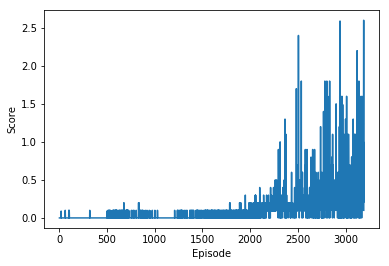

In [19]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()

In [20]:
fig.savefig('Episodes_tennis_0.5.png')